# Analysing CityModels with `pandas` and `scikit-learn`

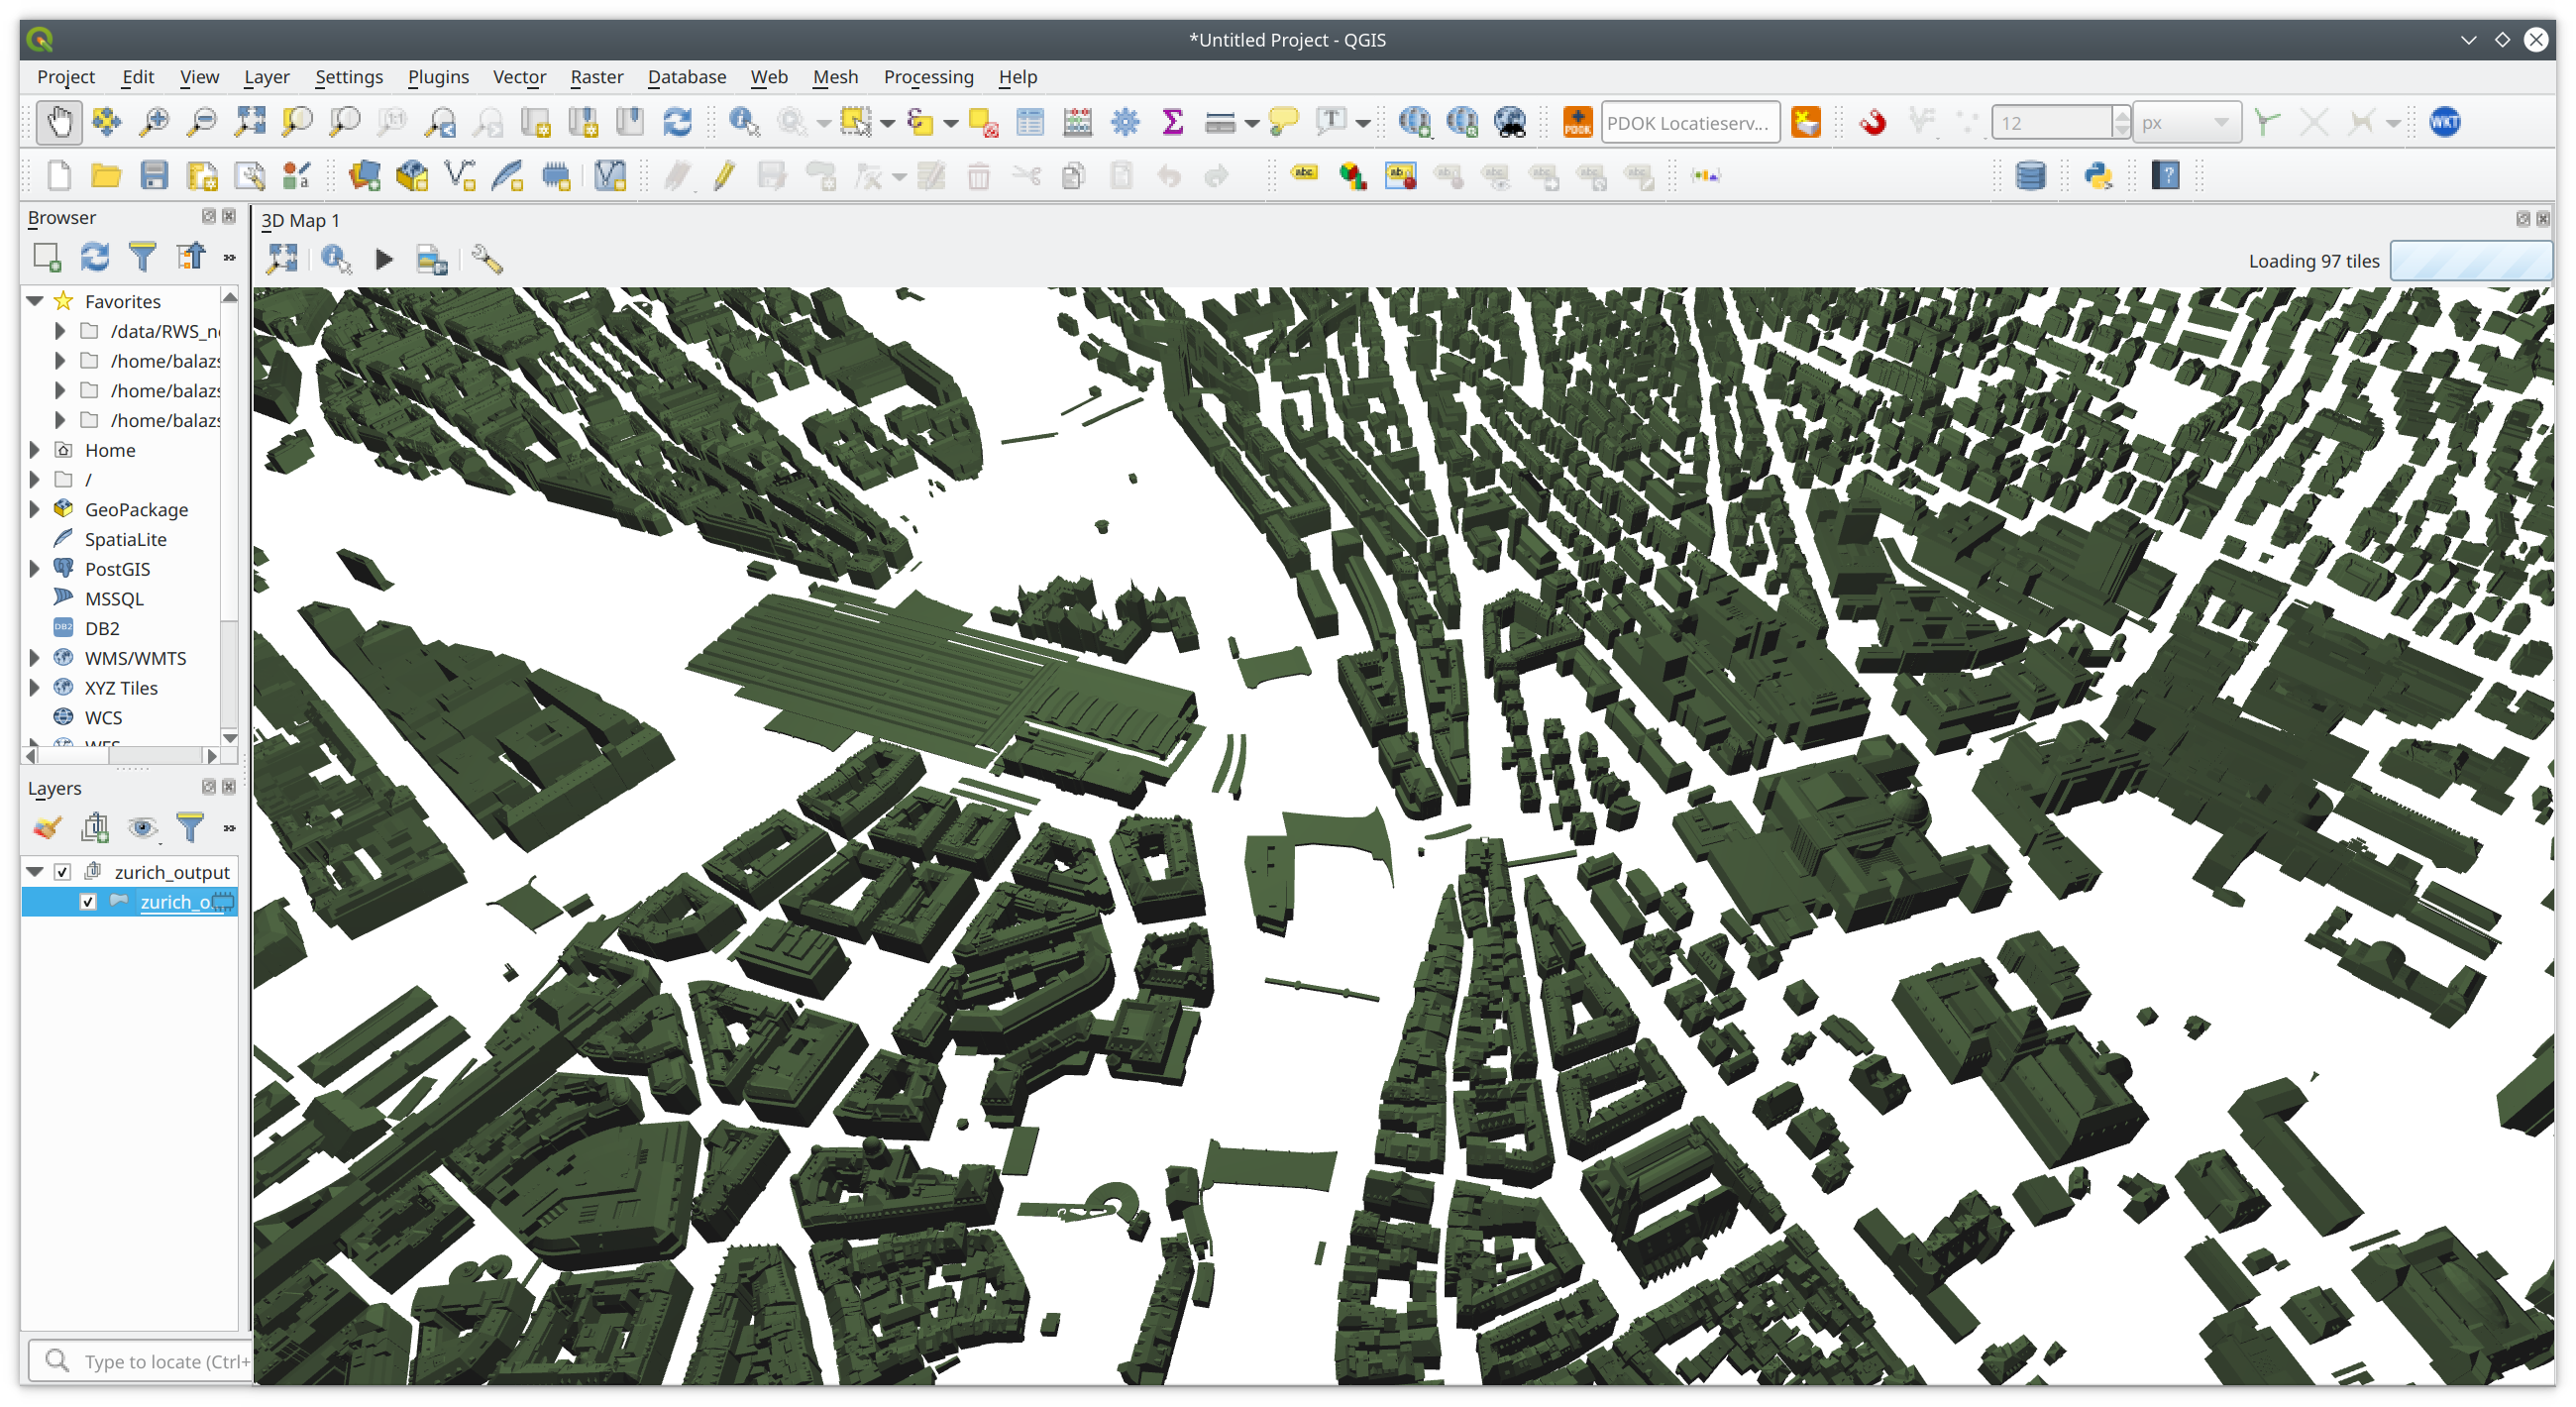

In the following I show how to compute some attributes from CityObject geometry and use these attributes as input for machine learning. For this we use the LoD2 model of Zürich.

Download the Zürich data set from https://3d.bk.tudelft.nl/opendata/cityjson/1.0/Zurich_Building_LoD2_V10.json

For this tutorial you'll need `pandas`, `shapely`, `matplotlib`, `numpy` and 
`scikit-learn`.

In [1]:
from pathlib import Path
from copy import deepcopy
from cjio import cityjson
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
plt.close('all')
from sklearn.preprocessing import FunctionTransformer
from sklearn import cluster
import numpy as np

Set up the paths for the tutorial.

In [2]:
package_dir = Path(__name__).resolve().parent.parent.parent
data_dir = package_dir / 'tests' / 'data'

path = data_dir / 'zurich' / 'zurich.json'
zurich = cityjson.load(path, transform=True)

## Feature engineering

Here is a simple geometry function that computes the area of the groundsurface (footprint) of buildings in the model. It also show how to cast surfaces, in this case the ground surface, to Shapely Polygons.

In [3]:
def compute_footprint_area(co):
    """Compute the area of the footprint"""
    footprint_area = 0
    for geom in co.geometry:
        
        # only LoD2 (or higher) objects have semantic surfaces
        if geom.lod >= 2.0:
            footprints = geom.get_surfaces(type='groundsurface')
            
            # there can be many surfaces with label 'groundsurface'
            for i,f in footprints.items():
                for multisurface in geom.get_surface_boundaries(f):
                    for surface in multisurface:
                        
                        # cast to Shapely polygon
                        shapely_poly = Polygon(surface)
                        footprint_area += shapely_poly.area
                        
    return footprint_area

### Compute new attributes

Then we need to loop through the CityObjects and update add the new attributes. Note that the `attributes` CityObject attribute is just a dictionary.

Thus we compute the number of vertices of the CityObject and the area of is footprint. Then we going to cluster these two variables. This is completely arbitrary excercise which is simply meant to illustrate how to transform a city model into machine-learnable features.

In [4]:
for co_id, co in zurich.cityobjects.items():
    co.attributes['nr_vertices'] = len(co.get_vertices())
    co.attributes['fp_area'] = compute_footprint_area(co)
    zurich.cityobjects[co_id] = co

## Export to DataFrame

It is possible to export the city model into a pandas DataFrame. Note that only the CityObject attributes are exported into the dataframe, with CityObject IDs as the index of the dataframe. Thus if you want to export the attributes of SemanticSurfaces for example, then you need to add them as CityObject attributes.

The function below illustrates this operation.

In [5]:
def assign_cityobject_attribute(cm):
    """Copy the semantic surface attributes to CityObject attributes.
    Returns a copy of the citymodel.
    """
    new_cos = {}
    cm_copy = deepcopy(cm)
    for co_id, co in cm.cityobjects.items():
        for geom in co.geometry:
            for srf in geom.surfaces.values():
                if 'attributes' in srf:
                    for attr,a_v in srf['attributes'].items():
                        if (attr not in co.attributes) or (co.attributes[attr] is None):
                            co.attributes[attr] = [a_v]
                        else:
                            co.attributes[attr].append(a_v)
        new_cos[co_id] = co
    cm_copy.cityobjects = new_cos
    return cm_copy

In [6]:
df = zurich.to_dataframe()
df.head()

creationDate  Geomtype  nr_vertices  \
UUID_93fc5bae-4446-4336-9ff8-6679ebfdfde3   2017-01-23       1.0           24   
UUID_c9884c4e-1cac-47f5-b88b-6fb074c0ae50   2017-01-23       NaN            0   
UUID_a4a09780-153f-4385-ad19-3a92a6c4eec4   2017-01-23       1.0           38   
UUID_ba0bb815-5276-4e35-b4c1-878cbf6ba934   2017-01-23       NaN            0   
UUID_bb1835bc-7437-453f-ac08-885de0503aaa   2017-01-23       1.0           87   

                                             fp_area class    Herkunft  \
UUID_93fc5bae-4446-4336-9ff8-6679ebfdfde3  65.209763   NaN         NaN   
UUID_c9884c4e-1cac-47f5-b88b-6fb074c0ae50   0.000000  BB01  EE_LB_2007   
UUID_a4a09780-153f-4385-ad19-3a92a6c4eec4  20.784309   NaN         NaN   
UUID_ba0bb815-5276-4e35-b4c1-878cbf6ba934   0.000000  BB07  EE_LB_2007   
UUID_bb1835bc-7437-453f-ac08-885de0503aaa  69.363823   NaN         NaN   

                                           QualitaetStatus FileCreationDate  \
UUID_93fc5bae-4446-4336-9ff8-6679ebfdfde3              NaN              NaN   
UUID_c9884c4e-1cac-47f5-b88b-6fb074c0ae50              1.0       2012-02-23   
UUID_a4a09780-153f-4385-ad19-3a92a6c4eec4              NaN              NaN   
UUID_ba0bb815-5276-4e35-b4c1-878cbf6ba934              1.0       2012-02-23   
UUID_bb1835bc-7437-453f-ac08-885de0503aaa              NaN              NaN   

                                           Region  GebaeudeStatus  
UUID_93fc5bae-4446-4336-9ff8-6679ebfdfde3     NaN             NaN  
UUID_c9884c4e-1cac-47f5-b88b-6fb074c0ae50     2.0             1.0  
UUID_a4a09780-153f-4385-ad19-3a92a6c4eec4     NaN             NaN  
UUID_ba0bb815-5276-4e35-b4c1-878cbf6ba934     2.0             1.0  
UUID_bb1835bc-7437-453f-ac08-885de0503aaa     NaN             NaN

In order to have a nicer distribution of the data, we remove the missing values and apply a log-transform on the two variables. Note that the `FuntionTransformer.transform` transforms a DataFrame to a numpy array that is ready to be used in `scikit-learn`. The details of a machine learning workflow is beyond the scope of this tutorial however.

In [7]:
df_subset = df[df['Geomtype'].notnull() & df['fp_area'] > 0.0].loc[:, ['nr_vertices', 'fp_area']]
transformer = FunctionTransformer(np.log, validate=True)
df_logtransform = transformer.transform(df_subset)

<IPython.core.display.Javascript object>


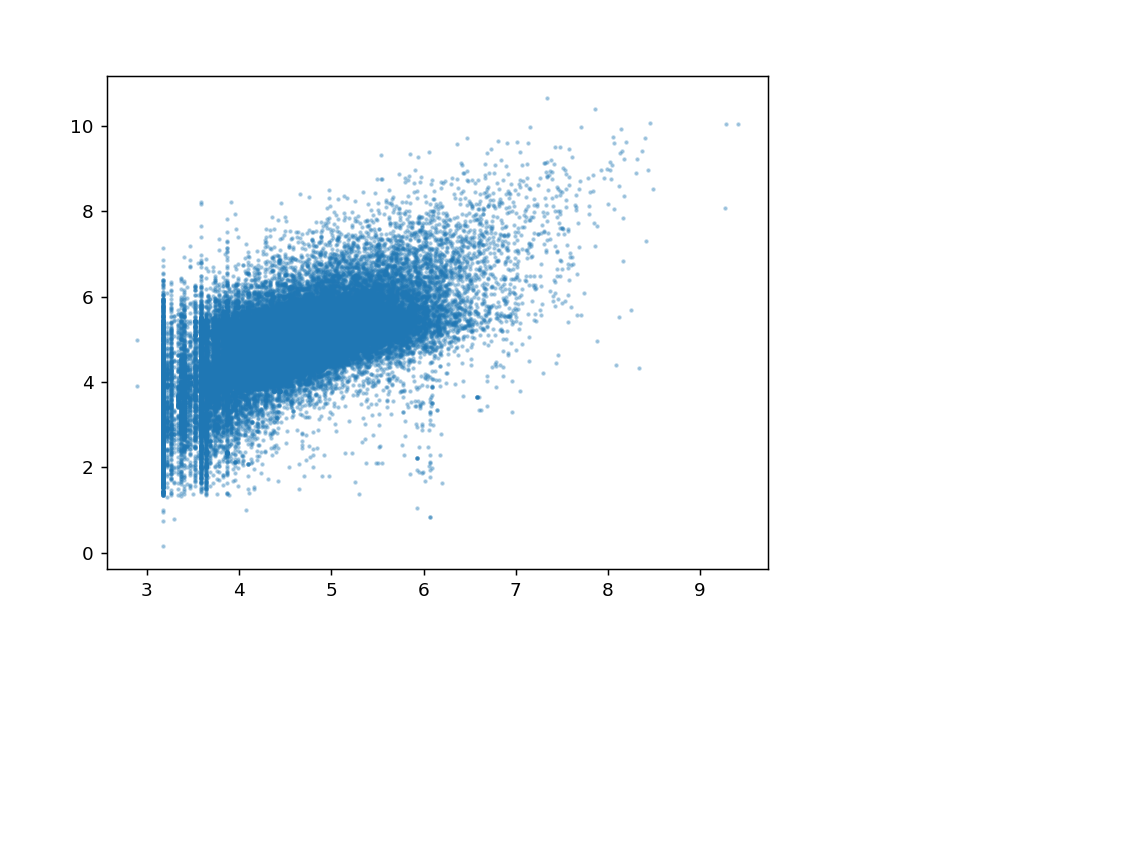

In [14]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(df_logtransform[:,0], df_logtransform[:,1], alpha=0.3, s=2.0)
plt.show()

In [9]:
def plot_model_results(model, data):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    colormap = np.array(['lightblue', 'red', 'lime', 'blue','black'])
    ax.scatter(data[:,0], data[:,1], c=colormap[model.labels_], s=10, alpha=0.5)
    ax.set_xlabel('Number of vertices [log]')
    ax.set_ylabel('Footprint area [log]')
    plt.title(f"DBSCAN clustering with estimated {len(set(model.labels_))} clusters")
    plt.show()

Since we transformed our DataFrame, we can fit any model in `scikit-learn`. I use DBSCAN because I wanted to find the data points on the fringes of the central cluster.

<IPython.core.display.Javascript object>


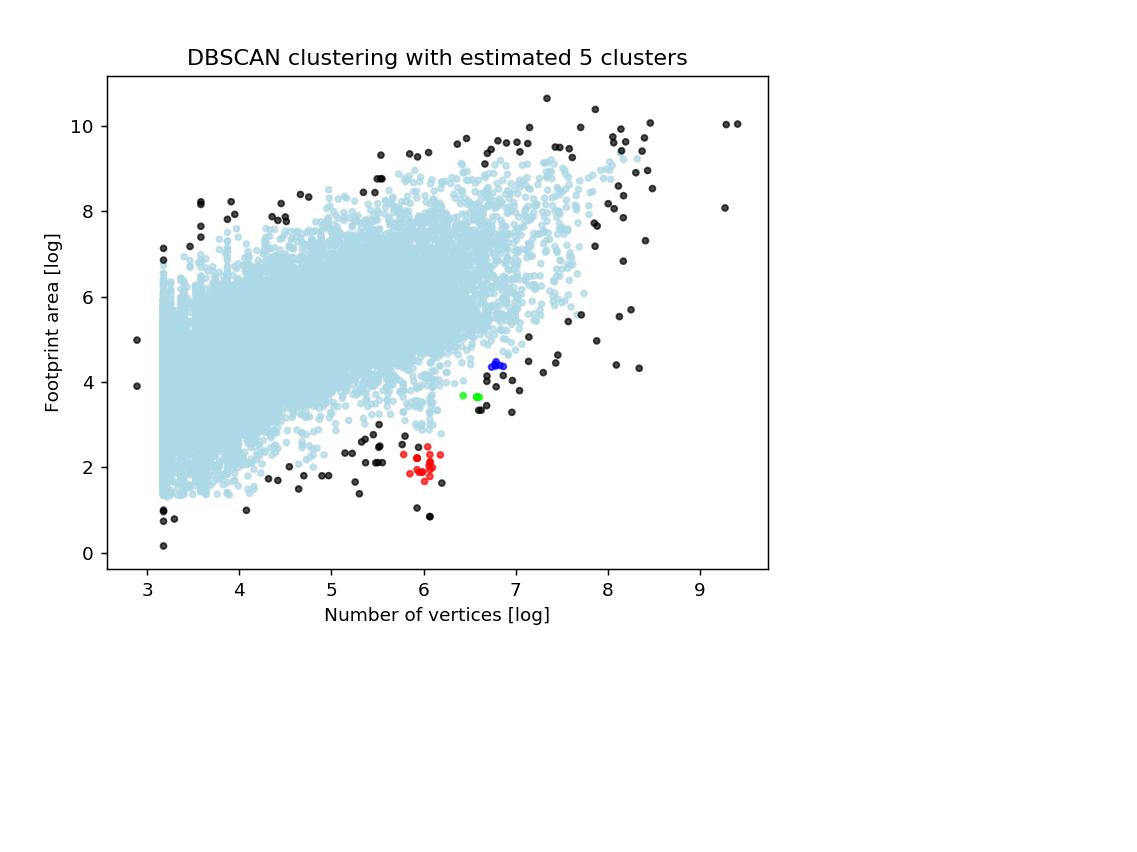

In [15]:
%matplotlib notebook
model = cluster.DBSCAN(eps=0.2).fit(df_logtransform)

plot_model_results(model, df_logtransform)

Merge the cluster labels back to the data frame.

In [11]:
df_subset['dbscan'] = model.labels_

## Save the results back to CityJSON

And merge the DataFrame with cluster labels back to the city model.

In [12]:
for co_id, co in zurich.cityobjects.items():
    if co_id in df_subset.index:
        ml_results = dict(df_subset.loc[co_id])
    else:
        ml_results = {'nr_vertices': 'nan', 'fp_area': 'nan', 'dbscan': 'nan'}
    new_attrs = {**co.attributes, **ml_results}
    co.attributes = new_attrs
    zurich.cityobjects[co_id] = co

At the end, the `save()` method saves the edited city model into a CityJSON file.

In [13]:
path_out = data_dir / 'zurich_output.json'
cityjson.save(zurich, path_out)

## And view the results in QGIS again

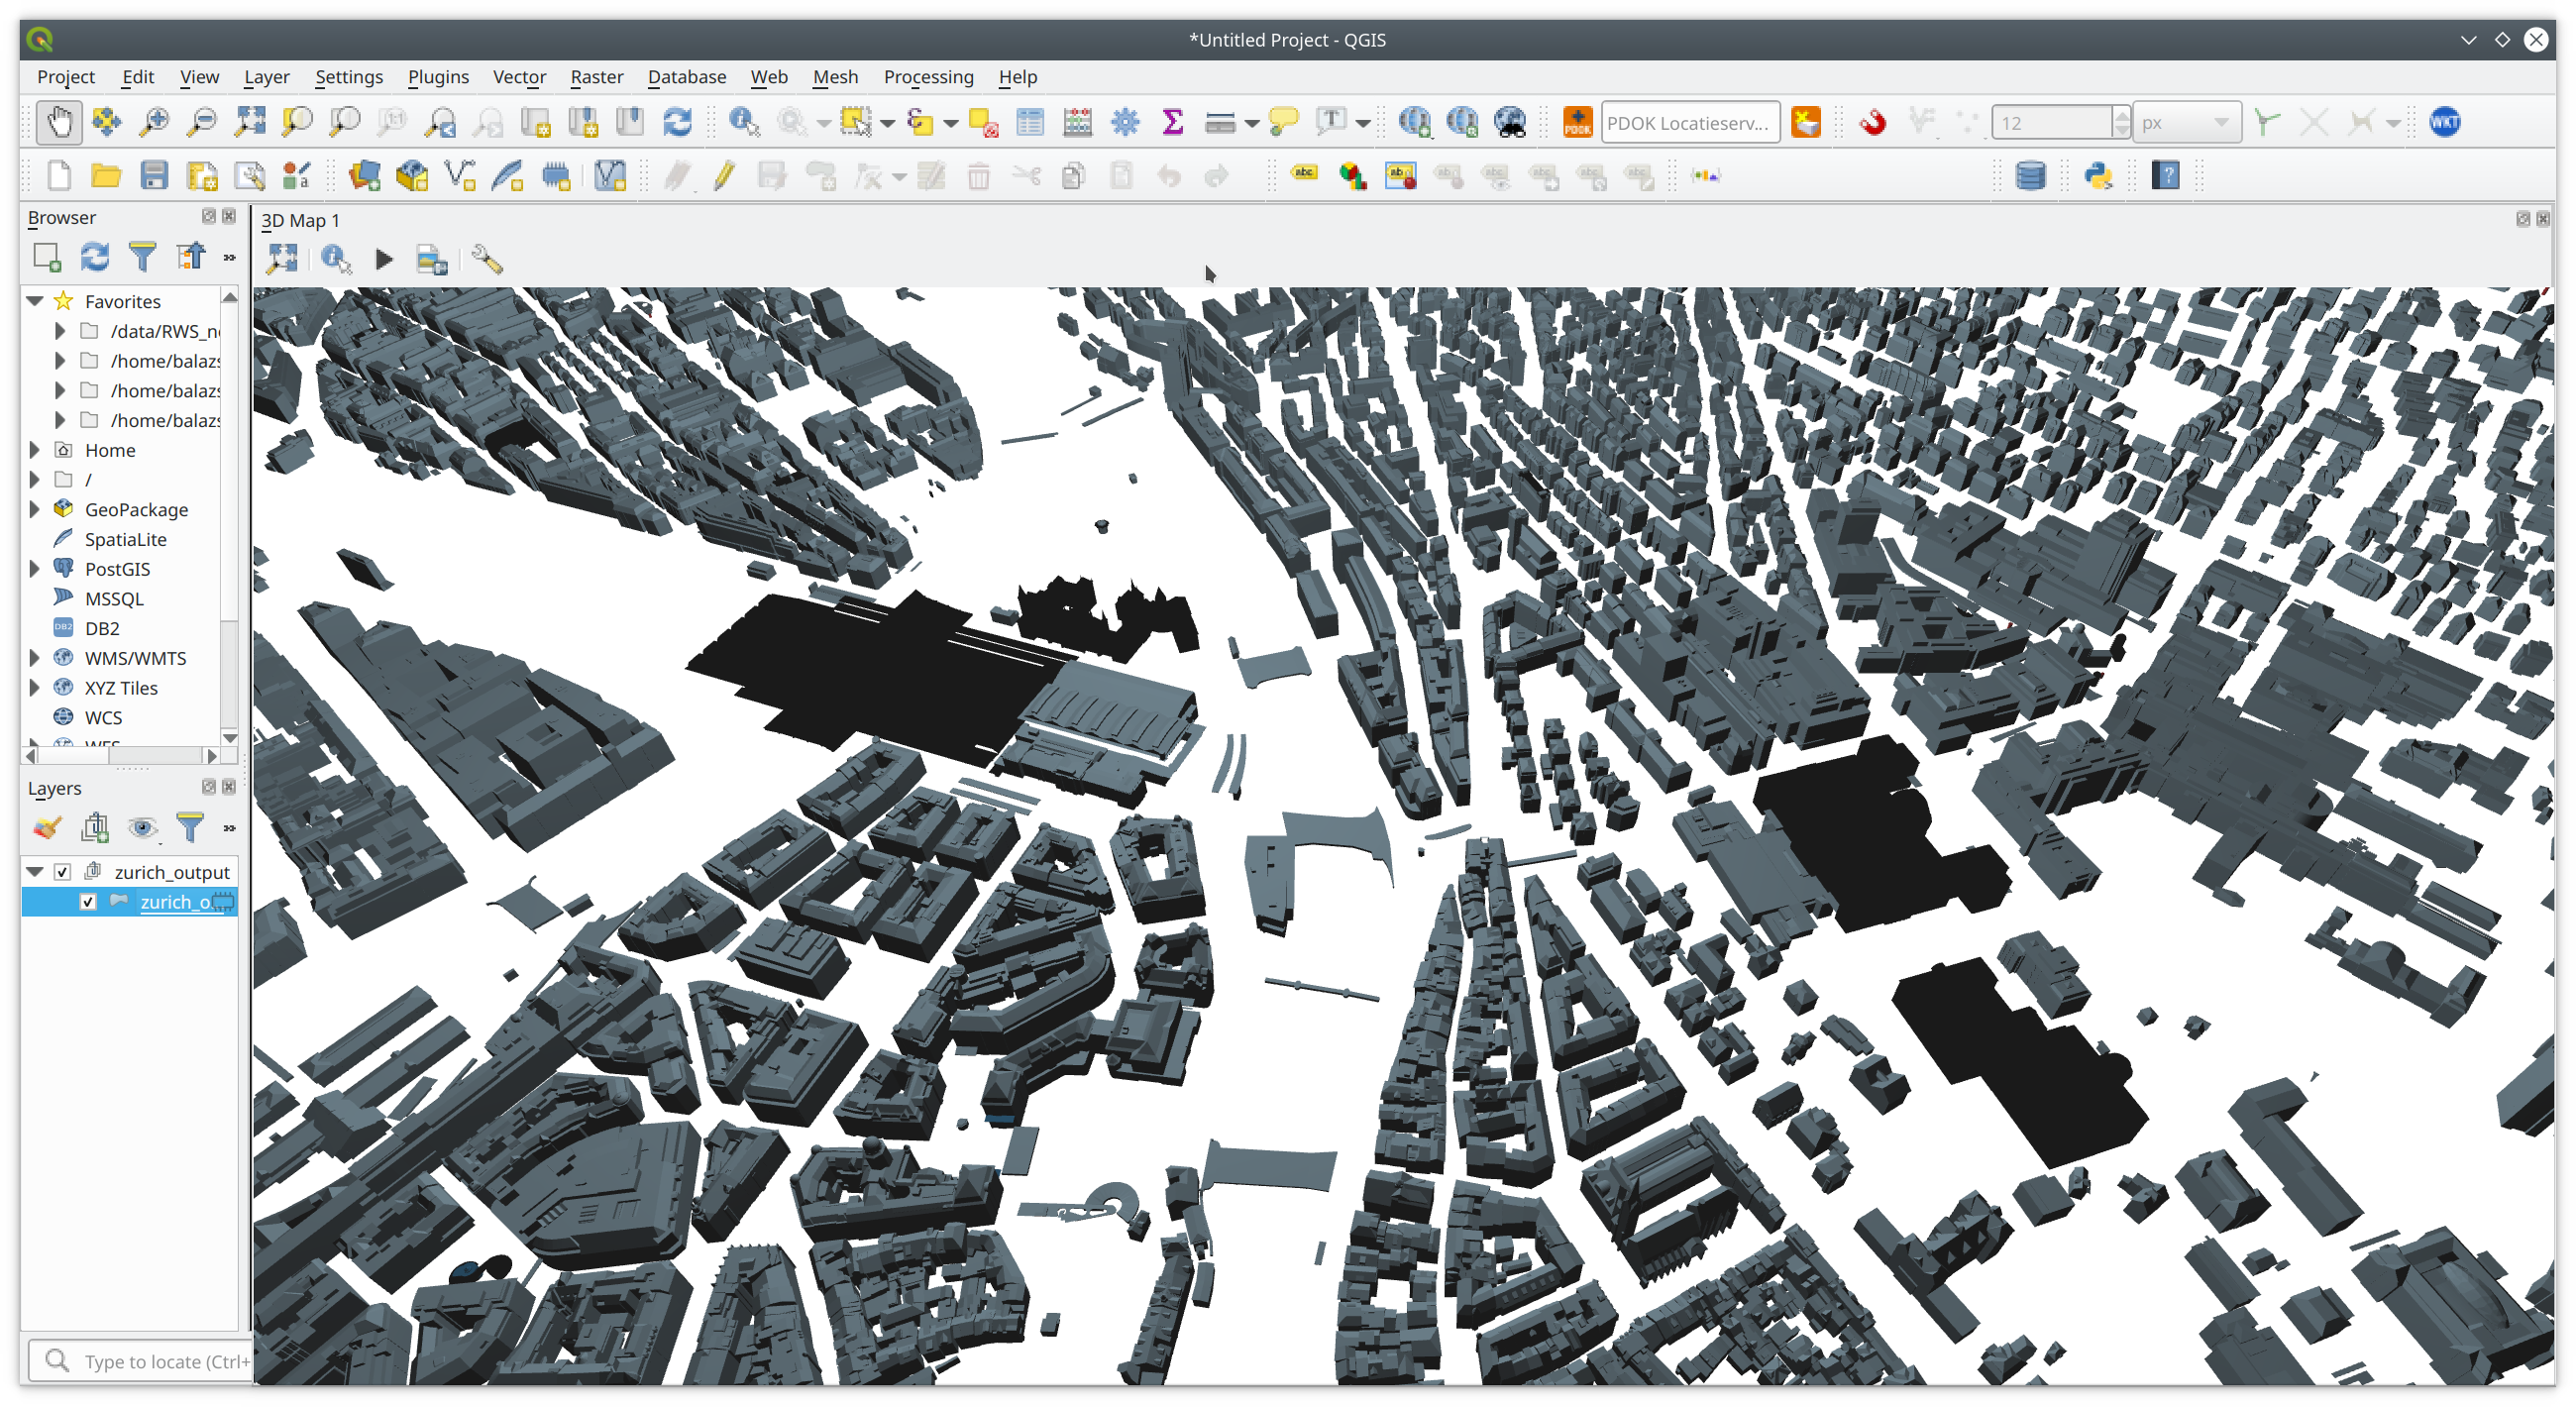

However, you'll need to set up the styling based on the cluster labels by hand.


